# TP 2: Cross validation

# Attention ! 
L'objectif de ces TPs est de vous apprendre à utiliser scikit-learn et à réfléchir aux résultats obtenus.
Je vous conseille très fortement de ne **pas** utiliser un LLM pour répondre à ces questions, mais plutôt la documentation de scikit-learn : https://scikit-learn.org/stable/

In [106]:
# A compléter ici :
# NOM : Andrieu
# Prénom : Ludovic
# N° étudiant : 22103219

## Cross validation pour Support Vector Machines

In [107]:
import pandas as pd

blood_transfusion = pd.read_csv("blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

blood_transfusion.info()
blood_transfusion.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Recency    748 non-null    int64 
 1   Frequency  748 non-null    int64 
 2   Monetary   748 non-null    int64 
 3   Time       748 non-null    int64 
 4   Class      748 non-null    object
dtypes: int64(4), object(1)
memory usage: 29.3+ KB


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated


Le but de cet exercice est de réaliser les expériences suivantes :

* entraîner et tester un classificateur de type « support vector machine » (SVM) par cross validation ;
* étudier l'effet du paramètre gamma de ce classificateur en utilisant une courbe de validation ;
* utiliser une courbe d'apprentissage pour déterminer l'utilité d'ajouter de nouveaux échantillons au jeu de données lors de la construction d'un classificateur.

Nous utilisons ici un classificateur de type « support vector machine » (SVM). Dans sa forme la plus simple, un classificateur SVM est un classificateur linéaire qui se comporte de manière similaire à une régression logistique. En effet, les optimisations utilisées pour trouver les poids optimaux du modèle linéaire sont différentes, mais nous n'avons pas besoin de connaître ces détails pour l'exercice.

De plus, ce classificateur peut devenir plus flexible/expressif en utilisant un noyau dit « kernel » qui rend le modèle non linéaire. Là encore, aucune compréhension des mathématiques n'est nécessaire pour réaliser cet exercice.

Nous utiliserons un noyau RBF où un paramètre `gamma` permet de régler la flexibilité du modèle.

Tout d'abord, créons une pipeline prédictive composée de :

  * un [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) avec les paramètres par défaut ;
  * un [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html\) où le paramètre `kernel` peut être défini à `"rbf"`. Notez que c'est la valeur par défaut.

In [108]:
# Write your code here.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(
    StandardScaler(), 
    SVC(kernel="rbf"))
model

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

Évaluez la performance de généralisation de votre modèle par cross validation avec un schéma `ShuffleSplit`. Ainsi, vous pouvez utiliser
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
et passez un
[`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
au paramètre `cv`. Fixez uniquement le `random_state=0` dans le `ShuffleSplit` et laissez les autres paramètres à la valeur par défaut.

In [109]:
# Write your code here.
from sklearn.model_selection import cross_validate, ShuffleSplit

results = cross_validate(model, data, target, cv=ShuffleSplit(random_state=0))
for key, arr in results.items():
    print(f"{key} -> mean: {arr.mean():.3g}, std: {arr.std():.3g}")

fit_time -> mean: 0.0288, std: 0.0105
score_time -> mean: 0.00415, std: 0.00017
test_score -> mean: 0.765, std: 0.0405


Comme mentionné précédemment, le paramètre `gamma` est l'un des paramètres qui contrôle le sous-apprentissage et le sur-apprentissage dans les machines à vecteurs de support avec un noyau RBF.

Évaluez l'effet du paramètre `gamma` en utilisant
[`sklearn.model_selection.ValidationCurveDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html).
Vous pouvez laisser le `scoring=None` par défaut, ce qui équivaut à
`scoring='accuracy'` pour les problèmes de classification. Vous pouvez faire varier `gamma` entre
`10e-3` et `10e2` en générant des échantillons sur une échelle logarithmique à l'aide de
`np.logspace(-3, 2, num=30)`.

Puisque nous manipulons un `Pipeline`, le nom du paramètre est `svc__gamma`
au lieu de simplement `gamma`. Vous pouvez récupérer le nom du paramètre en utilisant
`model.get_params().keys()`. Nous entrerons dans plus de détails concernant l'accès et le réglage des hyperparamètres dans la section suivante.

In [110]:
print(model.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


In [111]:
# Write your code here.
import numpy
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt


gamma_values = numpy.logspace(-3, 2, num=30)

(train_scores, test_scores) = validation_curve(
    model, data, target, param_name="svc__gamma", param_range=gamma_values,
    scoring="accuracy", cv=ShuffleSplit(random_state=0))


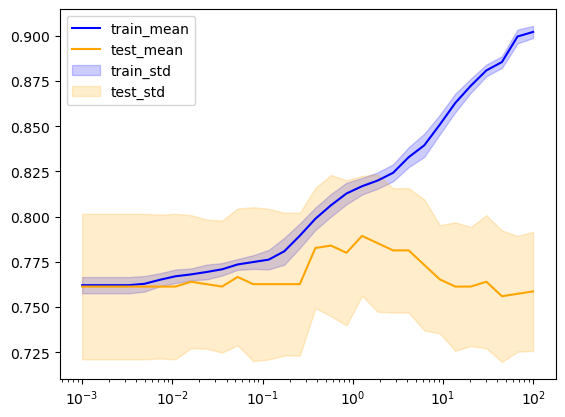

In [112]:
def validationCurveDisplay2(train_scores, test_scores, x, xscale):
    axe = plt.axes()
    axe.set_xscale(xscale)

    train_scores_mean = train_scores.mean(axis=-1)
    test_scores_mean = test_scores.mean(axis=-1)
    train_scores_std = train_scores.std(axis=-1)
    test_scores_std = test_scores.std(axis=-1)
    
    axe.plot(x, train_scores_mean, label="train_mean", c="blue")
    axe.plot(x, test_scores_mean, label="test_mean", c="orange")
    
    axe.fill_between(x, train_scores_mean+train_scores_std, train_scores_mean-train_scores_std, 
                     label="train_std", color="blue", alpha=0.2)
    axe.fill_between(x, test_scores_mean+test_scores_std, test_scores_mean-test_scores_std, 
                     label="test_std", color="orange", alpha=0.2)    
    
    axe.legend()
    plt.show()

validationCurveDisplay2(train_scores, test_scores, gamma_values, "log")

Maintenant, vous pouvez effectuer une analyse pour vérifier si l'ajout de nouveaux échantillons au jeu de données pourrait aider notre modèle à mieux généraliser. Calculez la courbe d'apprentissage (en utilisant
[`sklearn.model_selection.LearningCurveDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html)
en calculant les scores d'entraînement et de test pour différentes tailles de jeu de données d'entraînement. Tracez les scores d'entraînement et de test en fonction du nombre d'échantillons.

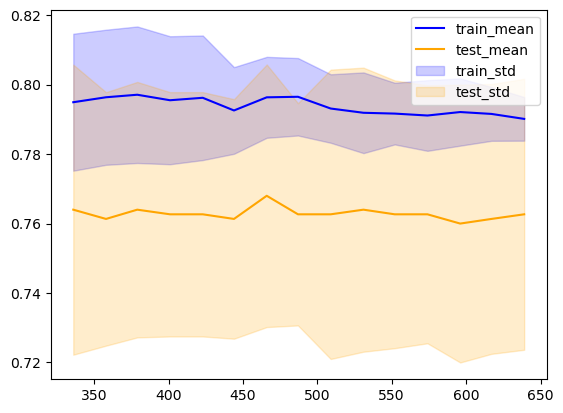

In [113]:
# Write your code here.
from sklearn.model_selection import LearningCurveDisplay, learning_curve

train_sizes, train_scores, test_scores, *others = learning_curve(
    model, data, target, cv=ShuffleSplit(random_state=0),
    train_sizes=numpy.linspace(0.5, 0.95, num=15))
if len(others) != 0:
    print(f"there was {len(others)} other outputs")

#curve = LearningCurveDisplay(
#    train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores)
#curve.plot()
#plt.show()
validationCurveDisplay2(train_scores, test_scores, train_sizes, "linear")

## Cross validation pour arbres de décisions

D'abord, créons un classificateur basé sur un arbre de décision

In [114]:
# Write your code here.
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

Créez un objet de validation croisée `StratifiedKFold`. Utilisez-le ensuite dans la fonction `cross_val_score` pour évaluer l'arbre de décision. Nous allons d'abord utiliser l'accuracy comme fonction de score. Utilisez explicitement le paramètre `scoring` de `cross_val_score` pour calculer l'accuracy (même s'il s'agit du score par défaut). Consultez sa documentation pour savoir comment faire.

In [115]:
# Write your code here.
from sklearn.model_selection import cross_val_score, StratifiedKFold

scores = cross_val_score(model, data, target, scoring="accuracy", cv=StratifiedKFold())
print(f"scores -> mean: {scores.mean():.3g}, std: {scores.std():.3g}")


scores -> mean: 0.615, std: 0.108


Répétez l'expérience avec `balanced_accuracy`.

In [116]:
# Write your code here.
scores = cross_val_score(model, data, target, scoring="balanced_accuracy", cv=StratifiedKFold())
print(f"scores -> mean: {scores.mean():.3g}, std: {scores.std():.3g}")


scores -> mean: 0.509, std: 0.0708


Nous allons maintenant ajouter un peu de complexité. Nous voulons calculer la precision de notre modèle.

Vous pouvez en lire plus à ce sujet ici :
[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

Nous devons mentionner le label positif, que nous considérons dans notre cas être la classe `donated`. Nous allons montrer que le calcul de la précision sans fournir le label positif ne sera pas supporté par scikit-learn car cela est en effet ambigu.

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
try:
    scores = cross_val_score(tree, data, target, cv=10, scoring="precision")
except ValueError as exc:
    print(exc)

/usr/lib/python3/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_

Nous obtenons une exception car le scorer par défaut a son label positif défini à un (`pos_label=1`), ce qui n'est pas notre cas (notre label positif est "donated"). Dans ce cas, nous devons créer un scorer en utilisant la fonction de scoring et la fonction utilitaire `make_scorer`.

Alors, importez `sklearn.metrics.make_scorer` et `sklearn.metrics.precision_score`. Consultez leurs documentations pour plus d'informations. Enfin, créez un scorer en appelant `make_scorer` en utilisant la fonction de score `precision_score` et passez le paramètre supplémentaire `pos_label="donated"`.

In [118]:
# Write your code here.
from sklearn.metrics import make_scorer, precision_score


prec_scorer = make_scorer(precision_score, greater_is_better=True, pos_label="donated")

Maintenant, au lieu de fournir la chaîne de caractères `"precision"` au paramètre `scoring` dans l'appel de `cross_val_score`, passez le scorer que vous avez créé ci-dessus.

In [119]:
# Write your code here.
scores = cross_val_score(model, data, target, cv=StratifiedKFold(n_splits=10), scoring=prec_scorer)
print(f"scores -> mean: {scores.mean():.3g}, std: {scores.std():.3g}")

scores -> mean: 0.237, std: 0.171


`cross_val_score` ne calcule qu'un seul score fourni au paramètre `scoring`. La fonction `cross_validate` permet le calcul de plusieurs scores en passant une liste de chaînes de caractères ou de scorers au paramètre `scoring`, ce qui peut être pratique.

Importez `sklearn.model_selection.cross_validate` et calculez l'accuracy et la balanced accuracy par cross validation. Tracez les scores de cross validation pour les deux métriques à l'aide d'un box plot.

fit_time -> mean: 0.00281, std: 9.31e-05
score_time -> mean: 0.00344, std: 0.000207
test_precision -> mean: 0.239, std: 0.172
test_balanced_accuracy -> mean: 0.502, std: 0.11
test_accuracy -> mean: 0.622, std: 0.146


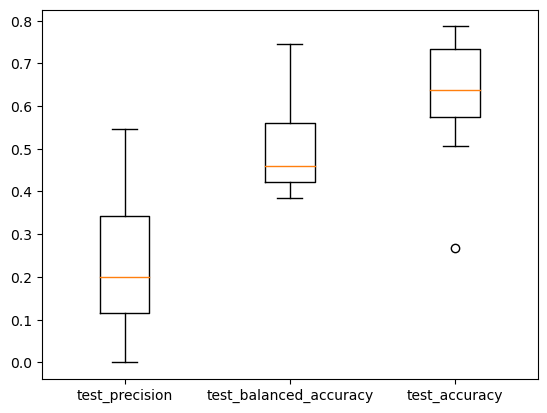

In [120]:
# Write your code here.
scores = cross_validate(
    model, data, target, cv=StratifiedKFold(n_splits=10), 
    scoring={"precision": prec_scorer, 
             "balanced_accuracy": "balanced_accuracy",
             "accuracy": "accuracy"})

for key, arr in scores.items():
    print(f"{key} -> mean: {arr.mean():.3g}, std: {arr.std():.3g}")

labels = ["test_precision", "test_balanced_accuracy", "test_accuracy"]

plt.boxplot([scores[k] for k in labels], labels=labels);

## Cross validation pour la régression

Nous allons évaluer les métriques de régression dans un cadre de cross validation afin de nous familiariser avec la syntaxe.

Nous utiliserons le jeu de données Ames house prices.

In [121]:
import pandas as pd
import numpy as np

ames_housing = pd.read_csv("house_prices.csv")
data = ames_housing.drop(columns="SalePrice")
target = ames_housing["SalePrice"]
data = data.select_dtypes(np.number)
target /= 1000

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   LotArea        1460 non-null   int64
 3   OverallQual    1460 non-null   int64
 4   OverallCond    1460 non-null   int64
 5   YearBuilt      1460 non-null   int64
 6   YearRemodAdd   1460 non-null   int64
 7   BsmtFinSF1     1460 non-null   int64
 8   BsmtFinSF2     1460 non-null   int64
 9   BsmtUnfSF      1460 non-null   int64
 10  TotalBsmtSF    1460 non-null   int64
 11  1stFlrSF       1460 non-null   int64
 12  2ndFlrSF       1460 non-null   int64
 13  LowQualFinSF   1460 non-null   int64
 14  GrLivArea      1460 non-null   int64
 15  BsmtFullBath   1460 non-null   int64
 16  BsmtHalfBath   1460 non-null   int64
 17  FullBath       1460 non-null   int64
 18  HalfBath       1460 non-null   int64
 19  Bedroo

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


La première étape est de créer un modèle de régression linéaire.

In [122]:
# Write your code here.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

model = make_pipeline(StandardScaler(), LinearRegression())
# model.fit(data, target)

Ensuite, utilisez la fonction `cross_val_score` pour estimer la performance de généralisation du modèle. Utilisez une validation croisée `KFold` avec 10 folds. Rendez explicite l'utilisation du score $R^2$ en assignant le paramètre `scoring` (même s'il s'agit du score par défaut).

In [123]:
# Write your code here.
scores = cross_val_score(model, data, target, cv=KFold(n_splits=10), scoring="r2")
print(f"scores -> mean: {scores.mean():.3g}, std: {scores.std():.3g}")

scores -> mean: 0.794, std: 0.103


Ensuite, au lieu d'utiliser le score $R^2$, utilisez la mean absolute error. Vous devez vous référer à la documentation pour le paramètre `scoring`.

In [124]:
# Write your code here.
from sklearn.metrics import mean_absolute_error


scores = cross_val_score(
    model, data, target, cv=KFold(n_splits=10), 
    scoring=make_scorer(mean_absolute_error))
print(f"scores -> mean: {scores.mean():.3g}, std: {scores.std():.3g}")

scores -> mean: 21.9, std: 2.22


Enfin, utilisez la fonction `cross_validate` et calculez plusieurs scores/erreurs à la fois en passant une liste de scorers au paramètre `scoring`. Vous pouvez par exemple calculer le score $R^2$ et la mean absolute error.

In [125]:
# Write your code here.
scores = cross_validate(
    model, data, target, cv=KFold(n_splits=10), 
    scoring={"mae": make_scorer(mean_absolute_error), 
             "R2": "r2"})
print(f"max of target is {target.max()}")

for key, arr in scores.items():
    print(f"{key} -> mean: {arr.mean():.3g}, std: {arr.std():.3g}")


max of target is 755.0
fit_time -> mean: 0.00814, std: 0.00267
score_time -> mean: 0.00262, std: 0.000107
test_mae -> mean: 21.9, std: 2.22
test_R2 -> mean: 0.794, std: 0.103
